In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 44.0 MB/s 
     |████████████████████████████████| 120 kB 63.5 MB/s 


In [ ]:
!nvidia-smi

Mon Sep 26 11:12:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import time
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim import Adam, SGD, AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, DataCollatorWithPadding
from transformers import BertTokenizer,AutoModel,AdamW,AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm
import copy
import torch.nn as nn
import os
import json
import gc
import random

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
class CFG:
    input_path = '/content/drive/MyDrive/ccf/'
    model_path = 'hfl/chinese-roberta-wwm-ext-large' #  nghuyong/ernie-2.0-large-en studio-ousia/luke-large
    scheduler = 'cosine'  # ['linear', 'cosine']
    batch_scheduler = True
    num_cycles = 0.5  # 1.5
    num_warmup_steps = 0
    max_input_length = 1024
    epochs = 100  # 5
    encoder_lr = 20e-6
    decoder_lr = 20e-6
    min_lr = 0.5e-6
    eps = 1e-6
    betas = (0.9, 0.999)
    weight_decay = 0
    num_fold = 5
    batch_size = 4
    seed = 1006
    OUTPUT_DIR = '/content/drive/MyDrive/ccf/'
    num_workers = 2
    device='cuda'
    print_freq = 100

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(CFG.seed)

## 1. Read Data & EDA

In [ ]:
def read_jsonfile(file_name):
    data = []
    with open(file_name) as f:
        for i in f.readlines():
            data.append(json.loads(i))
    return data

train = pd.DataFrame(read_jsonfile(CFG.input_path + "/train.json"))
#add = pd.read_csv('/content/drive/MyDrive/ccf/additional_train.csv')
#train = pd.concat([train, add])
test = pd.DataFrame(read_jsonfile(CFG.input_path + "/testA.json"))
train['label_id'] = train['label_id'].apply(lambda x :int(x))
train.reset_index(inplace=True)

In [ ]:
train.to_csv('train.csv', index=None)

,index,id,title,assignee,abstract,label_id
0,0,538f267d2e6fba48b1286fb7f1499fe7,一种信号的发送方法及基站、用户设备,华为技术有限公司,一种信号的发送方法及基站、用户设备。在一个子帧中为多个用户设备配置的参考信号的符号和数据的符...,0
1,1,635a7d4b6358b6ff24a324bb871505db,一种5G通讯电缆故障监控系统,中铁二十二局集团电气化工程有限公司,本发明公开了一种5G通讯电缆故障监控系统，包括信号采样模块、补偿反馈模块，所述信号采样模块对...,0
2,2,aaf98d6bfe1932cf1a262812ca59d1ba,一种测试方法及电子设备,腾讯科技(北京)有限公司,本发明提供了一种测试方法及电子设备，该方法包括：基于选取的测试任务确定目标测试用例，根据所述...,0
3,3,ad49c9ba6412452d9b25071af702f4fb,天线方位角调节装置,武汉虹信通信技术有限责任公司,一种天线方位角调节装置，包括对向的两个8字形支架(101)、动力输入电机(102)、主动齿轮...,0
4,4,ffa2d7617b3eac3a1d7df01e5bb515a2,光纤老化预测方法及装置,新华三大数据技术有限公司,本申请提供一种光纤老化预测方法及装置，所述方法包括：获取待测光纤模块可接收的光信号的告警阈值...,0
...,...,...,...,...,...,...
953,953,6af8c4c55c93ee38b8912db4576b3cfc,一种信息处理方法及装置,腾讯科技(深圳)有限公司,本发明公开了一种信息处理方法，所述方法包括：第一进程获取来自多个查询请求端的多个数据请求，所...,35
954,954,bc94427b0ae4c5a734ef7d32d6a1b9ea,一种适用于安防的广告机,靖江天元爱尔瑞电子科技有限公司,本实用新型公开了一种适用于安防的广告机，包括支撑架，支撑架的上端设置有显示屏，显示屏与壳体配...,35
955,955,2b1d9b24b86b2e49f842bd2c93cb865c,一种广告投放控制方法及装置,阿里巴巴(中国)有限公司,本发明公开了一种广告投放控制方法及装置，以解决现有技术中基于地域定向的广告投放方式准确度较低...,35
956,956,674baad2739c09bc9cc759322a0085c7,一种广告数据推荐方法和系统,北京奇艺世纪科技有限公司,本发明公开了一种广告数据推荐方法和系统。所述方法包括：接收到用户对目标广告数据的浏览请求后，...,35


### 1.1 Label Distribution

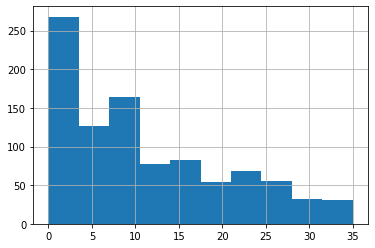

In [ ]:
train.label_id.hist()

In [ ]:
train.label_id.describe()

count    958.000000
mean      11.140919
std        9.325865
min        0.000000
25%        3.000000
50%        8.000000
75%       17.750000
max       35.000000
Name: label_id, dtype: float64

### 1.2 Input Length Analysis

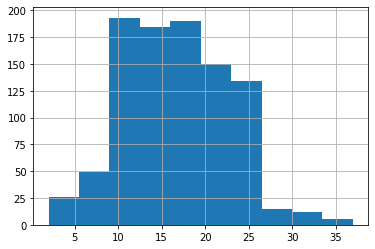

In [ ]:
train['title_len'] = train['title'].apply(lambda x: len(x))
train['title_len'].hist()

In [ ]:
train['title_len'].describe()

count    958.000000
mean      16.423800
std        6.028142
min        2.000000
25%       12.000000
50%       16.000000
75%       21.000000
max       37.000000
Name: title_len, dtype: float64

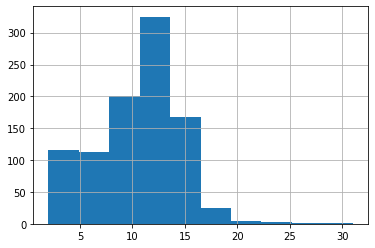

In [ ]:
train['assignee_len'] = train['assignee'].apply(lambda x: len(x))
train['assignee_len'].hist()

In [ ]:
train['assignee_len'].describe()

count    958.000000
mean      10.494781
std        4.019216
min        2.000000
25%        8.000000
50%       11.000000
75%       13.000000
max       31.000000
Name: assignee_len, dtype: float64

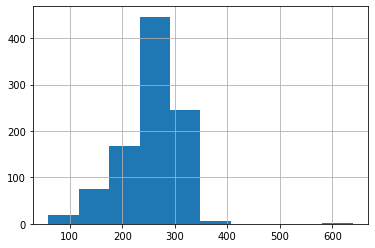

In [ ]:
train['abstract_len'] = train['abstract'].apply(lambda x: len(x))
train['abstract_len'].hist()

In [ ]:
train['abstract_len'].describe()

count    958.000000
mean     254.092902
std       52.885760
min       59.000000
25%      228.000000
50%      271.000000
75%      291.000000
max      639.000000
Name: abstract_len, dtype: float64

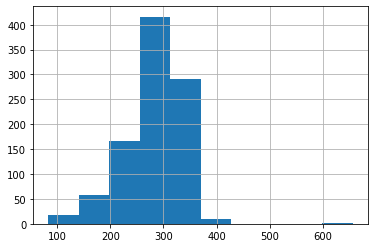

In [ ]:
train['input_text'] = train['title'] + train['assignee'] + train['abstract']
train['input_text_len'] = train['input_text'].apply(lambda x: len(x))
train['input_text_len'].hist()

结论：
训练数据较小仅有900条数据，test数据〉2w条，典型小样本训练场景
输入文本长度普遍在350个字以下，超过400的词很少
label的分布也不是很均衡，可能存在较难样本学习不充分的情况

In [ ]:
skf = StratifiedKFold(n_splits=5)
for fold, (_, val_) in enumerate(skf.split(X=train, y=train.label_id, groups=train.label_id)):
    train.loc[val_, "fold"] = int(fold)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
train

,index,id,title,assignee,abstract,label_id,title_len,assignee_len,abstract_len,input_text,input_text_len,fold
0,0,538f267d2e6fba48b1286fb7f1499fe7,一种信号的发送方法及基站、用户设备,华为技术有限公司,一种信号的发送方法及基站、用户设备。在一个子帧中为多个用户设备配置的参考信号的符号和数据的符...,0,17,8,265,一种信号的发送方法及基站、用户设备华为技术有限公司一种信号的发送方法及基站、用户设备。在一个...,290,0.0
1,1,635a7d4b6358b6ff24a324bb871505db,一种5G通讯电缆故障监控系统,中铁二十二局集团电气化工程有限公司,本发明公开了一种5G通讯电缆故障监控系统，包括信号采样模块、补偿反馈模块，所述信号采样模块对...,0,14,17,315,一种5G通讯电缆故障监控系统中铁二十二局集团电气化工程有限公司本发明公开了一种5G通讯电缆故...,346,0.0
2,2,aaf98d6bfe1932cf1a262812ca59d1ba,一种测试方法及电子设备,腾讯科技(北京)有限公司,本发明提供了一种测试方法及电子设备，该方法包括：基于选取的测试任务确定目标测试用例，根据所述...,0,11,12,180,一种测试方法及电子设备腾讯科技(北京)有限公司本发明提供了一种测试方法及电子设备，该方法包括...,203,0.0
3,3,ad49c9ba6412452d9b25071af702f4fb,天线方位角调节装置,武汉虹信通信技术有限责任公司,一种天线方位角调节装置，包括对向的两个8字形支架(101)、动力输入电机(102)、主动齿轮...,0,9,14,300,天线方位角调节装置武汉虹信通信技术有限责任公司一种天线方位角调节装置，包括对向的两个8字形支...,323,0.0
4,4,ffa2d7617b3eac3a1d7df01e5bb515a2,光纤老化预测方法及装置,新华三大数据技术有限公司,本申请提供一种光纤老化预测方法及装置，所述方法包括：获取待测光纤模块可接收的光信号的告警阈值...,0,11,12,236,光纤老化预测方法及装置新华三大数据技术有限公司本申请提供一种光纤老化预测方法及装置，所述方法...,259,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
953,953,6af8c4c55c93ee38b8912db4576b3cfc,一种信息处理方法及装置,腾讯科技(深圳)有限公司,本发明公开了一种信息处理方法，所述方法包括：第一进程获取来自多个查询请求端的多个数据请求，所...,35,11,12,246,一种信息处理方法及装置腾讯科技(深圳)有限公司本发明公开了一种信息处理方法，所述方法包括：第...,269,1.0
954,954,bc94427b0ae4c5a734ef7d32d6a1b9ea,一种适用于安防的广告机,靖江天元爱尔瑞电子科技有限公司,本实用新型公开了一种适用于安防的广告机，包括支撑架，支撑架的上端设置有显示屏，显示屏与壳体配...,35,11,15,292,一种适用于安防的广告机靖江天元爱尔瑞电子科技有限公司本实用新型公开了一种适用于安防的广告机，...,318,2.0
955,955,2b1d9b24b86b2e49f842bd2c93cb865c,一种广告投放控制方法及装置,阿里巴巴(中国)有限公司,本发明公开了一种广告投放控制方法及装置，以解决现有技术中基于地域定向的广告投放方式准确度较低...,35,13,12,216,一种广告投放控制方法及装置阿里巴巴(中国)有限公司本发明公开了一种广告投放控制方法及装置，以...,241,2.0
956,956,674baad2739c09bc9cc759322a0085c7,一种广告数据推荐方法和系统,北京奇艺世纪科技有限公司,本发明公开了一种广告数据推荐方法和系统。所述方法包括：接收到用户对目标广告数据的浏览请求后，...,35,13,12,233,一种广告数据推荐方法和系统北京奇艺世纪科技有限公司本发明公开了一种广告数据推荐方法和系统。所...,258,3.0


## 2. Build model Input and Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self,df,tokenizer):
        self.title = df['title'].values
        self.assignee = df['assignee'].values
        self.abstract = df['abstract'].values
        self.label = df['label_id'].values
        self.tokenizer = tokenizer
        self.sep_token = tokenizer.sep_token
    def __len__(self):
        return len(self.title)
    def __getitem__(self, item):
        label = int(self.label[item])
        title = self.title[item]
        assignee = self.assignee[item]
        abstract = self.abstract[item]
        input_text =  title + self.sep_token + assignee + self.sep_token + abstract
        inputs = self.tokenizer(input_text, truncation=True, max_length=400, padding='max_length')
        return torch.as_tensor(inputs['input_ids'], dtype=torch.long), \
               torch.as_tensor(inputs['attention_mask'], dtype=torch.long), \
               torch.as_tensor(label, dtype=torch.long)

class TrainPETDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.title = df['title'].values
        self.assignee = df['assignee'].values
        self.abstract = df['abstract'].values
        self.label = df['label_id'].values
        self.tokenizer = tokenizer
        self.sep_token = tokenizer.sep_token
        self.mask_token = tokenizer.mask_token

    def __len__(self):
        return len(self.title)

    def __getitem__(self, item):
        label = '通信'  # self.label[item]
        title = self.title[item]
        assignee = self.assignee[item]
        abstract = self.abstract[item]
        input_text = '本发明设计' + self.mask_token+ self.mask_token + '领域，具体如下' + title + self.sep_token + assignee + self.sep_token + abstract
        inputs = self.tokenizer(input_text, truncation=True, max_length=400, padding='max_length')
        label = self.tokenizer(label, truncation=True, max_length=2, padding='max_length', add_special_tokens=False)[
            'input_ids']
        return torch.as_tensor(inputs['input_ids'] + [self.pad_token] * len(label), dtype=torch.long), \
               torch.as_tensor(inputs['attention_mask'] + [0] * len(label), dtype=torch.long), \
               torch.as_tensor([-100] * len(inputs['input_ids']) + label, dtype=torch.long)

## 3. Build Model

In [ ]:
from transformers import BertTokenizer, AlbertForSequenceClassification
# model = AlbertForSequenceClassification.from_pretrained(CFG.model_path,num_labels=36)
# tokenizer = BertTokenizer.from_pretrained(CFG.model_path)
model = AutoModelForSequenceClassification.from_pretrained(CFG.model_path,num_labels=36,ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(CFG.model_path)

from transformers.modeling_outputs import SequenceClassifierOutput, AutoModelForMaskedLM

class Custom_Bert_Simple(nn.Module):
    def __init__(self):
        super().__init__()

        self.base = AutoModelForSequenceClassification.from_pretrained(CFG.model_path, num_labels=36)

    def forward(self, input_ids, attention_mask, labels=None):
        base_output = self.base(input_ids=input_ids,
                                attention_mask=attention_mask,
                                )

        output = base_output[0]
        loss = None
        if labels:
            loss = F.cross_entropy(output, labels)
        return SequenceClassifierOutput(logits=output, loss=loss)

class CCFModelPET(nn.Module):
    def __init__(self):
        super().__init__()
        # Backbone
        self.backbone = AutoModelForMaskedLM.from_pretrained(CFG.model_path)  # 加载预训练模型
        self.config = AutoConfig.from_pretrained(CFG.model_path)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.backbone(input_ids=input_ids,
                               attention_mask=attention_mask,
                               ).logits # batch_size, seq_len, hidden_size

        loss = None
        if labels is not None:
            loss = F.cross_entropy(output.view(-1, self.config.vocab_size), labels.view(-1))
        return SequenceClassifierOutput(logits=output, loss=loss)

class Custom_Bert_Mean(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(CFG.model_path)
        config.output_hidden_states = True
        self.base = AutoModel.from_pretrained(CFG.model_path, config=config)
        dim = config.hidden_size
        self.dropout = nn.Dropout(p=0.2)
        self.cls = nn.Linear(dim, 36)

    def forward(self, input_ids, attention_mask, labels=None):
        base_output = self.base(input_ids=input_ids,
                                attention_mask=attention_mask,
                                )

        output = base_output.hidden_states[-1] # b, s ,h
        output = self.cls(self.dropout(torch.mean(output, dim=1)))
        loss = None
        if labels:
            loss = F.cross_entropy(output, labels)
        return SequenceClassifierOutput(logits=output, loss=loss)

class CCFModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Backbone
        self.config = AutoConfig.from_pretrained(CFG.model_path)
        self.config.max_position_embeddings=2000
        self.backbone = AutoModel.from_pretrained(CFG.model_path, config=self.config)  # 加载预训练模型
        
        # Multidropout
        self.dropout1 = nn.Dropout(0.1)  # dropout 0.1
        self.dropout2 = nn.Dropout(0.2)  # dropout 0.2
        self.dropout3 = nn.Dropout(0.3)  # dropout 0.3
        self.dropout4 = nn.Dropout(0.4)  # dropout 0.4
        self.dropout5 = nn.Dropout(0.5)  # dropout 0.5

        # GRU
        self.rnn = nn.GRU(
            input_size=self.config.hidden_size,  # 输入大小
            hidden_size=self.config.hidden_size // 2,  # 隐藏层大小
            bidirectional=True,  # 双向
            batch_first=True,  # batch在最前面的维度
            dropout=0.1,  # dropout 0.1
            num_layers=1  # 层数
        )

        # Head
        self.head = nn.Linear(self.config.hidden_size, 36)  # 线性层

        self._init_weights(self.head)  # 初始化权重

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)


    def forward(self, input_ids, attention_mask, labels=None):
        output_backbone = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # batch_size, seq_len, hidden_size
        output_backbone = self.rnn(output_backbone)[0]  # GRU

        output1 = self.head(self.dropout1(torch.mean(output_backbone, dim=1)))  # dropout 0.1 + 线性层
        output2 = self.head(self.dropout2(torch.mean(output_backbone, dim=1)))  # dropout 0.2 + 线性层
        output3 = self.head(self.dropout3(torch.mean(output_backbone, dim=1)))  # dropout 0.3 + 线性层
        output4 = self.head(self.dropout4(torch.mean(output_backbone, dim=1)))  # dropout 0.4 + 线性层
        output5 = self.head(self.dropout5(torch.mean(output_backbone, dim=1)))  # dropout 0.5 + 线性层

        output = (output1 + output2 + output3 + output4 + output5) / 5  # 平均
        loss = None
        if labels:
            loss = F.cross_entropy(output, labels)
        return SequenceClassifierOutput(logits=output, loss=loss)


Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext-large were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the mod

## 4.Build train pipeline

In [ ]:
def get_score(preds, gts):
    return f1_score(preds, gts, average='macro')

In [ ]:
def train_fn(train_loader, model, optimizer, epoch, scheduler, device):
    model.train()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, batch in enumerate(train_loader):
        label = batch[2].to(device)
        mask = batch[1].to(device)
        input_ids = batch[0].to(device)
        batch_size = label.size(0)
        output = model(input_ids, mask, labels=label)
        loss = output.loss
        losses.update(loss.item(), batch_size)
        optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 500)
        optimizer.step()
        global_step += 1
        scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    return losses.avg

def valid_fn(valid_loader, model, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    labels = []
    start = end = time.time()
    for step, batch in enumerate(valid_loader):
        label = batch[2].to(device)
        mask = batch[1].to(device)
        input_ids = batch[0].to(device)
        batch_size = label.size(0)
        with torch.no_grad():
            output = model(input_ids, mask, labels=label)
        loss = output.loss
        y_preds = output.logits.argmax(dim=-1)
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        labels.append(label.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    labels = np.concatenate(labels)
    #print(predictions)
    return losses.avg, predictions, labels


def train_loop(fold, model, train_dataset, valid_dataset):
    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    #model = Custom_Bert_Simple()
    #model = AutoModelForSequenceClassification.from_pretrained(CFG.model_path, num_labels=1)
    model.to(CFG.device)

    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr,
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        cfg.num_warmup_steps = cfg.num_warmup_steps * num_train_steps
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps,
                num_cycles=cfg.num_cycles
            )
        return scheduler

    num_train_steps = int(len(train_dataset) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = torch.nn.CrossEntropyLoss(ignore_index=- 1)

    # criterion = LabelSmoothingLoss()
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, optimizer, epoch, scheduler, CFG.device)

        # eval
        avg_val_loss, predictions, valid_labels = valid_fn(valid_loader, model, CFG.device)

        # scoring
        score = get_score(predictions, valid_labels)

        elapsed = time.time() - start_time

        LOGGER.info(
            f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch + 1} - Score: {score:.4f}')


        if best_score < score:
            best_score = score
            best_predictions = predictions
            LOGGER.info(f'Epoch {epoch + 1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                       CFG.OUTPUT_DIR + "{}_best{}.pth".format(CFG.model_path.replace('/', '_'),fold))



    torch.cuda.empty_cache()
    gc.collect()
    del scheduler, optimizer, model
    return best_predictions


## 5.Build Logger

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def get_logger(filename=CFG.OUTPUT_DIR+ 'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()
LOGGER.info('===============lr_{}==============='.format(CFG.encoder_lr))
LOGGER.info('===============seed_{}==============='.format(CFG.seed))
LOGGER.info('===============total_epochs_{}==============='.format(CFG.epochs))
LOGGER.info('===============num_warmup_steps_{}==============='.format(CFG.num_warmup_steps))

===============lr_2e-05===============
INFO:__main__:===============lr_2e-05===============
===============seed_1006===============
INFO:__main__:===============seed_1006===============
===============total_epochs_100===============
INFO:__main__:===============total_epochs_100===============
===============num_warmup_steps_0===============
INFO:__main__:===============num_warmup_steps_0===============


In [ ]:
fold = 1
tr_data = train[train['fold']!=fold].reset_index(drop=True)
va_data = train[train['fold']==fold].reset_index(drop=True)
tr_dataset = TrainDataset(tr_data,tokenizer)
va_dataset =TrainDataset(va_data,tokenizer)
val_result = train_loop(fold, model,tr_dataset, va_dataset)

========== training ==========
INFO:__main__:========== training ==========
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [1][0/191] Elapsed 0m 4s (remain 15m 15s) Loss: 3.5488(3.5488) Grad: 13.0020  LR: 0.00002000  
Epoch: [1][100/191] Elapsed 0m 38s (remain 0m 34s) Loss: 2.5828(2.9586) Grad: 16.7794  LR: 0.00002000  
Epoch: [1][190/191] Elapsed 1m 8s (remain 0m 0s) Loss: 1.9054(2.6613) Grad: 21.3975  LR: 0.00002000  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 2.6157(2.6157) 


Epoch 1 - avg_train_loss: 2.6613  avg_val_loss: 2.0746  time: 74s
INFO:__main__:Epoch 1 - avg_train_loss: 2.6613  avg_val_loss: 2.0746  time: 74s
Epoch 1 - Score: 0.1869
INFO:__main__:Epoch 1 - Score: 0.1869
Epoch 1 - Save Best Score: 0.1869 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.1869 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 3.3931(2.0746) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [2][0/191] Elapsed 0m 0s (remain 1m 35s) Loss: 1.5163(1.5163) Grad: 13.7322  LR: 0.00002000  
Epoch: [2][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 2.7374(1.4954) Grad: 19.6205  LR: 0.00001999  
Epoch: [2][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 1.9643(1.4713) Grad: 16.3520  LR: 0.00001998  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 1.5080(1.5080) 


Epoch 2 - avg_train_loss: 1.4713  avg_val_loss: 1.5826  time: 70s
INFO:__main__:Epoch 2 - avg_train_loss: 1.4713  avg_val_loss: 1.5826  time: 70s
Epoch 2 - Score: 0.4734
INFO:__main__:Epoch 2 - Score: 0.4734
Epoch 2 - Save Best Score: 0.4734 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.4734 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 2.1568(1.5826) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [3][0/191] Elapsed 0m 0s (remain 1m 35s) Loss: 0.3562(0.3562) Grad: 5.4441  LR: 0.00001998  
Epoch: [3][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.1093(0.7673) Grad: 3.7203  LR: 0.00001997  
Epoch: [3][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.8818(0.7756) Grad: 15.7862  LR: 0.00001996  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 1.7146(1.7146) 


Epoch 3 - avg_train_loss: 0.7756  avg_val_loss: 1.5846  time: 70s
INFO:__main__:Epoch 3 - avg_train_loss: 0.7756  avg_val_loss: 1.5846  time: 70s
Epoch 3 - Score: 0.4847
INFO:__main__:Epoch 3 - Score: 0.4847
Epoch 3 - Save Best Score: 0.4847 Model
INFO:__main__:Epoch 3 - Save Best Score: 0.4847 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.9844(1.5846) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [4][0/191] Elapsed 0m 0s (remain 1m 36s) Loss: 0.1299(0.1299) Grad: 4.1922  LR: 0.00001996  
Epoch: [4][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.1837(0.4743) Grad: 5.0585  LR: 0.00001994  
Epoch: [4][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.3904(0.4073) Grad: 8.3013  LR: 0.00001992  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 1.6991(1.6991) 


Epoch 4 - avg_train_loss: 0.4073  avg_val_loss: 1.7411  time: 70s
INFO:__main__:Epoch 4 - avg_train_loss: 0.4073  avg_val_loss: 1.7411  time: 70s
Epoch 4 - Score: 0.4499
INFO:__main__:Epoch 4 - Score: 0.4499


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.6357(1.7411) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [5][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.2392(0.2392) Grad: 9.2585  LR: 0.00001992  
Epoch: [5][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.1078(0.2762) Grad: 2.5687  LR: 0.00001990  
Epoch: [5][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0600(0.2460) Grad: 1.9213  LR: 0.00001988  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.3118(3.3118) 


Epoch 5 - avg_train_loss: 0.2460  avg_val_loss: 1.6975  time: 70s
INFO:__main__:Epoch 5 - avg_train_loss: 0.2460  avg_val_loss: 1.6975  time: 70s
Epoch 5 - Score: 0.5155
INFO:__main__:Epoch 5 - Score: 0.5155
Epoch 5 - Save Best Score: 0.5155 Model
INFO:__main__:Epoch 5 - Save Best Score: 0.5155 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.1406(1.6975) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [6][0/191] Elapsed 0m 0s (remain 1m 39s) Loss: 0.3123(0.3123) Grad: 48.6012  LR: 0.00001988  
Epoch: [6][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0570(0.1449) Grad: 1.8789  LR: 0.00001985  
Epoch: [6][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0719(0.1466) Grad: 5.3434  LR: 0.00001982  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 1.3702(1.3702) 


Epoch 6 - avg_train_loss: 0.1466  avg_val_loss: 2.2607  time: 70s
INFO:__main__:Epoch 6 - avg_train_loss: 0.1466  avg_val_loss: 2.2607  time: 70s
Epoch 6 - Score: 0.5094
INFO:__main__:Epoch 6 - Score: 0.5094


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.8203(2.2607) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [7][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0367(0.0367) Grad: 0.8717  LR: 0.00001982  
Epoch: [7][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0254(0.0555) Grad: 0.4780  LR: 0.00001979  
Epoch: [7][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0353(0.0687) Grad: 1.1923  LR: 0.00001976  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 2.2791(2.2791) 


Epoch 7 - avg_train_loss: 0.0687  avg_val_loss: 1.9738  time: 70s
INFO:__main__:Epoch 7 - avg_train_loss: 0.0687  avg_val_loss: 1.9738  time: 70s
Epoch 7 - Score: 0.4676
INFO:__main__:Epoch 7 - Score: 0.4676


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.3196(1.9738) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [8][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0680(0.0680) Grad: 2.0532  LR: 0.00001976  
Epoch: [8][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0180(0.0536) Grad: 0.3610  LR: 0.00001972  
Epoch: [8][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0217(0.0501) Grad: 0.3352  LR: 0.00001969  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 1.0715(1.0715) 


Epoch 8 - avg_train_loss: 0.0501  avg_val_loss: 1.8931  time: 70s
INFO:__main__:Epoch 8 - avg_train_loss: 0.0501  avg_val_loss: 1.8931  time: 70s
Epoch 8 - Score: 0.5178
INFO:__main__:Epoch 8 - Score: 0.5178
Epoch 8 - Save Best Score: 0.5178 Model
INFO:__main__:Epoch 8 - Save Best Score: 0.5178 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.3948(1.8931) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [9][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0273(0.0273) Grad: 0.9649  LR: 0.00001969  
Epoch: [9][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0166(0.0556) Grad: 0.4406  LR: 0.00001965  
Epoch: [9][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0144(0.0454) Grad: 0.6487  LR: 0.00001960  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 1.6427(1.6427) 


Epoch 9 - avg_train_loss: 0.0454  avg_val_loss: 1.8434  time: 70s
INFO:__main__:Epoch 9 - avg_train_loss: 0.0454  avg_val_loss: 1.8434  time: 70s
Epoch 9 - Score: 0.4882
INFO:__main__:Epoch 9 - Score: 0.4882


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.3384(1.8434) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [10][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0198(0.0198) Grad: 0.6847  LR: 0.00001960  
Epoch: [10][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0223(0.0382) Grad: 0.4056  LR: 0.00001956  
Epoch: [10][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0111(0.0295) Grad: 0.2094  LR: 0.00001951  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 2.3388(2.3388) 


Epoch 10 - avg_train_loss: 0.0295  avg_val_loss: 2.0786  time: 70s
INFO:__main__:Epoch 10 - avg_train_loss: 0.0295  avg_val_loss: 2.0786  time: 70s
Epoch 10 - Score: 0.4923
INFO:__main__:Epoch 10 - Score: 0.4923


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.1479(2.0786) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [11][0/191] Elapsed 0m 0s (remain 1m 32s) Loss: 0.0102(0.0102) Grad: 0.2163  LR: 0.00001951  
Epoch: [11][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0075(0.0208) Grad: 0.1603  LR: 0.00001946  
Epoch: [11][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0170(0.0322) Grad: 0.6203  LR: 0.00001941  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.0675(3.0675) 


Epoch 11 - avg_train_loss: 0.0322  avg_val_loss: 2.0899  time: 70s
INFO:__main__:Epoch 11 - avg_train_loss: 0.0322  avg_val_loss: 2.0899  time: 70s
Epoch 11 - Score: 0.5214
INFO:__main__:Epoch 11 - Score: 0.5214
Epoch 11 - Save Best Score: 0.5214 Model
INFO:__main__:Epoch 11 - Save Best Score: 0.5214 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.0782(2.0899) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [12][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0198(0.0198) Grad: 0.5404  LR: 0.00001941  
Epoch: [12][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0414(0.1009) Grad: 1.7561  LR: 0.00001935  
Epoch: [12][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0242(0.1622) Grad: 0.8405  LR: 0.00001930  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 1.5136(1.5136) 


Epoch 12 - avg_train_loss: 0.1622  avg_val_loss: 2.3700  time: 70s
INFO:__main__:Epoch 12 - avg_train_loss: 0.1622  avg_val_loss: 2.3700  time: 70s
Epoch 12 - Score: 0.4460
INFO:__main__:Epoch 12 - Score: 0.4460


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.4793(2.3700) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [13][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0354(0.0354) Grad: 1.4652  LR: 0.00001930  
Epoch: [13][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0142(0.2886) Grad: 0.5370  LR: 0.00001924  
Epoch: [13][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 1.0603(0.2525) Grad: 33.9911  LR: 0.00001918  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 2.2979(2.2979) 


Epoch 13 - avg_train_loss: 0.2525  avg_val_loss: 1.8963  time: 70s
INFO:__main__:Epoch 13 - avg_train_loss: 0.2525  avg_val_loss: 1.8963  time: 70s
Epoch 13 - Score: 0.4770
INFO:__main__:Epoch 13 - Score: 0.4770


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.2937(1.8963) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [14][0/191] Elapsed 0m 0s (remain 1m 26s) Loss: 0.1402(0.1402) Grad: 24.5238  LR: 0.00001918  
Epoch: [14][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.1488(0.1610) Grad: 24.3868  LR: 0.00001911  
Epoch: [14][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0343(0.1643) Grad: 1.6380  LR: 0.00001905  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.6070(3.6070) 


Epoch 14 - avg_train_loss: 0.1643  avg_val_loss: 2.2110  time: 70s
INFO:__main__:Epoch 14 - avg_train_loss: 0.1643  avg_val_loss: 2.2110  time: 70s
Epoch 14 - Score: 0.4858
INFO:__main__:Epoch 14 - Score: 0.4858


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 1.3174(2.2110) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [15][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0218(0.0218) Grad: 0.5198  LR: 0.00001905  
Epoch: [15][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0226(0.0949) Grad: 1.0083  LR: 0.00001898  
Epoch: [15][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0216(0.0957) Grad: 2.0277  LR: 0.00001892  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.6264(3.6264) 


Epoch 15 - avg_train_loss: 0.0957  avg_val_loss: 2.3331  time: 70s
INFO:__main__:Epoch 15 - avg_train_loss: 0.0957  avg_val_loss: 2.3331  time: 70s
Epoch 15 - Score: 0.4651
INFO:__main__:Epoch 15 - Score: 0.4651


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.8204(2.3331) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [16][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0135(0.0135) Grad: 0.3970  LR: 0.00001891  
Epoch: [16][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0082(0.0301) Grad: 0.1913  LR: 0.00001884  
Epoch: [16][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0056(0.0268) Grad: 0.0884  LR: 0.00001877  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.5216(3.5216) 


Epoch 16 - avg_train_loss: 0.0268  avg_val_loss: 2.3206  time: 70s
INFO:__main__:Epoch 16 - avg_train_loss: 0.0268  avg_val_loss: 2.3206  time: 70s
Epoch 16 - Score: 0.5199
INFO:__main__:Epoch 16 - Score: 0.5199


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6047(2.3206) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [17][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0059(0.0059) Grad: 0.1548  LR: 0.00001877  
Epoch: [17][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0150(0.0100) Grad: 0.5007  LR: 0.00001869  
Epoch: [17][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0067(0.0087) Grad: 0.2535  LR: 0.00001861  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.5009(3.5009) 


Epoch 17 - avg_train_loss: 0.0087  avg_val_loss: 2.4078  time: 70s
INFO:__main__:Epoch 17 - avg_train_loss: 0.0087  avg_val_loss: 2.4078  time: 70s
Epoch 17 - Score: 0.5017
INFO:__main__:Epoch 17 - Score: 0.5017


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6077(2.4078) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [18][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0033(0.0033) Grad: 0.0767  LR: 0.00001861  
Epoch: [18][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0040(0.0061) Grad: 0.1266  LR: 0.00001853  
Epoch: [18][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0039(0.0057) Grad: 0.0590  LR: 0.00001845  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.5255(3.5255) 


Epoch 18 - avg_train_loss: 0.0057  avg_val_loss: 2.4346  time: 70s
INFO:__main__:Epoch 18 - avg_train_loss: 0.0057  avg_val_loss: 2.4346  time: 70s
Epoch 18 - Score: 0.5091
INFO:__main__:Epoch 18 - Score: 0.5091


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6022(2.4346) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [19][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0036(0.0036) Grad: 0.0817  LR: 0.00001845  
Epoch: [19][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0024(0.0050) Grad: 0.0408  LR: 0.00001836  
Epoch: [19][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0064(0.0049) Grad: 0.1215  LR: 0.00001828  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.5496(3.5496) 


Epoch 19 - avg_train_loss: 0.0049  avg_val_loss: 2.4621  time: 69s
INFO:__main__:Epoch 19 - avg_train_loss: 0.0049  avg_val_loss: 2.4621  time: 69s
Epoch 19 - Score: 0.5048
INFO:__main__:Epoch 19 - Score: 0.5048


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6068(2.4621) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [20][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0038(0.0038) Grad: 0.0769  LR: 0.00001828  
Epoch: [20][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0044(0.0044) Grad: 0.0986  LR: 0.00001819  
Epoch: [20][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0059(0.0043) Grad: 0.1075  LR: 0.00001810  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.5862(3.5862) 


Epoch 20 - avg_train_loss: 0.0043  avg_val_loss: 2.4947  time: 69s
INFO:__main__:Epoch 20 - avg_train_loss: 0.0043  avg_val_loss: 2.4947  time: 69s
Epoch 20 - Score: 0.5048
INFO:__main__:Epoch 20 - Score: 0.5048


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6068(2.4947) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [21][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0027(0.0027) Grad: 0.0397  LR: 0.00001810  
Epoch: [21][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0027(0.0041) Grad: 0.0440  LR: 0.00001800  
Epoch: [21][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0026(0.0039) Grad: 0.0529  LR: 0.00001791  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.6335(3.6335) 


Epoch 21 - avg_train_loss: 0.0039  avg_val_loss: 2.5261  time: 69s
INFO:__main__:Epoch 21 - avg_train_loss: 0.0039  avg_val_loss: 2.5261  time: 69s
Epoch 21 - Score: 0.5128
INFO:__main__:Epoch 21 - Score: 0.5128


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6123(2.5261) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [22][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0048(0.0048) Grad: 0.1179  LR: 0.00001791  
Epoch: [22][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0048(0.0036) Grad: 0.0837  LR: 0.00001781  
Epoch: [22][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0040(0.0035) Grad: 0.0934  LR: 0.00001772  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.6640(3.6640) 


Epoch 22 - avg_train_loss: 0.0035  avg_val_loss: 2.5530  time: 70s
INFO:__main__:Epoch 22 - avg_train_loss: 0.0035  avg_val_loss: 2.5530  time: 70s
Epoch 22 - Score: 0.5124
INFO:__main__:Epoch 22 - Score: 0.5124


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6111(2.5530) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [23][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0027(0.0027) Grad: 0.0454  LR: 0.00001772  
Epoch: [23][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0031(0.0032) Grad: 0.0552  LR: 0.00001761  
Epoch: [23][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0021(0.0031) Grad: 0.0381  LR: 0.00001751  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.6929(3.6929) 


Epoch 23 - avg_train_loss: 0.0031  avg_val_loss: 2.5810  time: 70s
INFO:__main__:Epoch 23 - avg_train_loss: 0.0031  avg_val_loss: 2.5810  time: 70s
Epoch 23 - Score: 0.5118
INFO:__main__:Epoch 23 - Score: 0.5118


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6072(2.5810) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [24][0/191] Elapsed 0m 0s (remain 1m 25s) Loss: 0.0033(0.0033) Grad: 0.0537  LR: 0.00001751  
Epoch: [24][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0028(0.0029) Grad: 0.0461  LR: 0.00001740  
Epoch: [24][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0016(0.0028) Grad: 0.0213  LR: 0.00001730  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.7070(3.7070) 


Epoch 24 - avg_train_loss: 0.0028  avg_val_loss: 2.6054  time: 69s
INFO:__main__:Epoch 24 - avg_train_loss: 0.0028  avg_val_loss: 2.6054  time: 69s
Epoch 24 - Score: 0.5171
INFO:__main__:Epoch 24 - Score: 0.5171


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6093(2.6054) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [25][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0025(0.0025) Grad: 0.0432  LR: 0.00001730  
Epoch: [25][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0027(0.0027) Grad: 0.0515  LR: 0.00001719  
Epoch: [25][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0027(0.0026) Grad: 0.0386  LR: 0.00001709  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.7357(3.7357) 


Epoch 25 - avg_train_loss: 0.0026  avg_val_loss: 2.6272  time: 70s
INFO:__main__:Epoch 25 - avg_train_loss: 0.0026  avg_val_loss: 2.6272  time: 70s
Epoch 25 - Score: 0.5138
INFO:__main__:Epoch 25 - Score: 0.5138


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6128(2.6272) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [26][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0031(0.0031) Grad: 0.0480  LR: 0.00001708  
Epoch: [26][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0022(0.0024) Grad: 0.0598  LR: 0.00001697  
Epoch: [26][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0013(0.0024) Grad: 0.0205  LR: 0.00001686  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.7662(3.7662) 


Epoch 26 - avg_train_loss: 0.0024  avg_val_loss: 2.6522  time: 69s
INFO:__main__:Epoch 26 - avg_train_loss: 0.0024  avg_val_loss: 2.6522  time: 69s
Epoch 26 - Score: 0.5138
INFO:__main__:Epoch 26 - Score: 0.5138


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6148(2.6522) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [27][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0035(0.0035) Grad: 0.0587  LR: 0.00001686  
Epoch: [27][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0009(0.0022) Grad: 0.0171  LR: 0.00001674  
Epoch: [27][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0020(0.0022) Grad: 0.0310  LR: 0.00001663  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.7869(3.7869) 


Epoch 27 - avg_train_loss: 0.0022  avg_val_loss: 2.6767  time: 70s
INFO:__main__:Epoch 27 - avg_train_loss: 0.0022  avg_val_loss: 2.6767  time: 70s
Epoch 27 - Score: 0.5138
INFO:__main__:Epoch 27 - Score: 0.5138


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6135(2.6767) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [28][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0018(0.0018) Grad: 0.0288  LR: 0.00001663  
Epoch: [28][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0025(0.0020) Grad: 0.0483  LR: 0.00001650  
Epoch: [28][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0012(0.0020) Grad: 0.0181  LR: 0.00001639  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.8074(3.8074) 


Epoch 28 - avg_train_loss: 0.0020  avg_val_loss: 2.7036  time: 70s
INFO:__main__:Epoch 28 - avg_train_loss: 0.0020  avg_val_loss: 2.7036  time: 70s
Epoch 28 - Score: 0.5171
INFO:__main__:Epoch 28 - Score: 0.5171


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6167(2.7036) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [29][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0029(0.0029) Grad: 0.0470  LR: 0.00001639  
Epoch: [29][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0021(0.0020) Grad: 0.0431  LR: 0.00001626  
Epoch: [29][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0020(0.0019) Grad: 0.0273  LR: 0.00001615  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.8450(3.8450) 


Epoch 29 - avg_train_loss: 0.0019  avg_val_loss: 2.7281  time: 70s
INFO:__main__:Epoch 29 - avg_train_loss: 0.0019  avg_val_loss: 2.7281  time: 70s
Epoch 29 - Score: 0.5206
INFO:__main__:Epoch 29 - Score: 0.5206


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6215(2.7281) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [30][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0016(0.0016) Grad: 0.0264  LR: 0.00001615  
Epoch: [30][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0022(0.0018) Grad: 0.0423  LR: 0.00001602  
Epoch: [30][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0019(0.0018) Grad: 0.0320  LR: 0.00001590  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.8886(3.8886) 


Epoch 30 - avg_train_loss: 0.0018  avg_val_loss: 2.7553  time: 70s
INFO:__main__:Epoch 30 - avg_train_loss: 0.0018  avg_val_loss: 2.7553  time: 70s
Epoch 30 - Score: 0.5206
INFO:__main__:Epoch 30 - Score: 0.5206


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6222(2.7553) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [31][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0014(0.0014) Grad: 0.0238  LR: 0.00001590  
Epoch: [31][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0020(0.0017) Grad: 0.0279  LR: 0.00001576  
Epoch: [31][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0017(0.0017) Grad: 0.0367  LR: 0.00001564  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.9120(3.9120) 


Epoch 31 - avg_train_loss: 0.0017  avg_val_loss: 2.7767  time: 70s
INFO:__main__:Epoch 31 - avg_train_loss: 0.0017  avg_val_loss: 2.7767  time: 70s
Epoch 31 - Score: 0.5206
INFO:__main__:Epoch 31 - Score: 0.5206


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6225(2.7767) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [32][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0012(0.0012) Grad: 0.0225  LR: 0.00001564  
Epoch: [32][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0011(0.0015) Grad: 0.0186  LR: 0.00001550  
Epoch: [32][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0016(0.0015) Grad: 0.0216  LR: 0.00001538  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.9498(3.9498) 


Epoch 32 - avg_train_loss: 0.0015  avg_val_loss: 2.8023  time: 70s
INFO:__main__:Epoch 32 - avg_train_loss: 0.0015  avg_val_loss: 2.8023  time: 70s
Epoch 32 - Score: 0.5206
INFO:__main__:Epoch 32 - Score: 0.5206


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6186(2.8023) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [33][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0025(0.0025) Grad: 0.0432  LR: 0.00001538  
Epoch: [33][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0013(0.0014) Grad: 0.0215  LR: 0.00001524  
Epoch: [33][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0021(0.0014) Grad: 0.0364  LR: 0.00001511  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 3.9708(3.9708) 


Epoch 33 - avg_train_loss: 0.0014  avg_val_loss: 2.8264  time: 70s
INFO:__main__:Epoch 33 - avg_train_loss: 0.0014  avg_val_loss: 2.8264  time: 70s
Epoch 33 - Score: 0.5216
INFO:__main__:Epoch 33 - Score: 0.5216
Epoch 33 - Save Best Score: 0.5216 Model
INFO:__main__:Epoch 33 - Save Best Score: 0.5216 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6223(2.8264) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [34][0/191] Elapsed 0m 0s (remain 1m 34s) Loss: 0.0011(0.0011) Grad: 0.0173  LR: 0.00001511  
Epoch: [34][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0012(0.0013) Grad: 0.0200  LR: 0.00001497  
Epoch: [34][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0015(0.0013) Grad: 0.0251  LR: 0.00001484  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.0062(4.0062) 


Epoch 34 - avg_train_loss: 0.0013  avg_val_loss: 2.8530  time: 70s
INFO:__main__:Epoch 34 - avg_train_loss: 0.0013  avg_val_loss: 2.8530  time: 70s
Epoch 34 - Score: 0.5177
INFO:__main__:Epoch 34 - Score: 0.5177


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6232(2.8530) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [35][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0011(0.0011) Grad: 0.0194  LR: 0.00001484  
Epoch: [35][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0014(0.0013) Grad: 0.0210  LR: 0.00001470  
Epoch: [35][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0010(0.0012) Grad: 0.0155  LR: 0.00001457  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.0336(4.0336) 


Epoch 35 - avg_train_loss: 0.0012  avg_val_loss: 2.8778  time: 70s
INFO:__main__:Epoch 35 - avg_train_loss: 0.0012  avg_val_loss: 2.8778  time: 70s
Epoch 35 - Score: 0.5166
INFO:__main__:Epoch 35 - Score: 0.5166


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6235(2.8778) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [36][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0008(0.0008) Grad: 0.0120  LR: 0.00001456  
Epoch: [36][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0011(0.0011) Grad: 0.0165  LR: 0.00001442  
Epoch: [36][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0007(0.0011) Grad: 0.0113  LR: 0.00001428  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.0608(4.0608) 


Epoch 36 - avg_train_loss: 0.0011  avg_val_loss: 2.9034  time: 70s
INFO:__main__:Epoch 36 - avg_train_loss: 0.0011  avg_val_loss: 2.9034  time: 70s
Epoch 36 - Score: 0.5166
INFO:__main__:Epoch 36 - Score: 0.5166


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6238(2.9034) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [37][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0018(0.0018) Grad: 0.0311  LR: 0.00001428  
Epoch: [37][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0007(0.0011) Grad: 0.0124  LR: 0.00001413  
Epoch: [37][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0009(0.0011) Grad: 0.0128  LR: 0.00001400  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.0841(4.0841) 


Epoch 37 - avg_train_loss: 0.0011  avg_val_loss: 2.9262  time: 69s
INFO:__main__:Epoch 37 - avg_train_loss: 0.0011  avg_val_loss: 2.9262  time: 69s
Epoch 37 - Score: 0.5166
INFO:__main__:Epoch 37 - Score: 0.5166


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6222(2.9262) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [38][0/191] Elapsed 0m 0s (remain 1m 26s) Loss: 0.0013(0.0013) Grad: 0.0198  LR: 0.00001400  
Epoch: [38][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0008(0.0010) Grad: 0.0121  LR: 0.00001385  
Epoch: [38][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0005(0.0010) Grad: 0.0082  LR: 0.00001371  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.1082(4.1082) 


Epoch 38 - avg_train_loss: 0.0010  avg_val_loss: 2.9483  time: 70s
INFO:__main__:Epoch 38 - avg_train_loss: 0.0010  avg_val_loss: 2.9483  time: 70s
Epoch 38 - Score: 0.5215
INFO:__main__:Epoch 38 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6216(2.9483) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [39][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0013(0.0013) Grad: 0.0213  LR: 0.00001371  
Epoch: [39][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0006(0.0009) Grad: 0.0081  LR: 0.00001356  
Epoch: [39][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0007(0.0009) Grad: 0.0106  LR: 0.00001342  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.1291(4.1291) 


Epoch 39 - avg_train_loss: 0.0009  avg_val_loss: 2.9698  time: 70s
INFO:__main__:Epoch 39 - avg_train_loss: 0.0009  avg_val_loss: 2.9698  time: 70s
Epoch 39 - Score: 0.5215
INFO:__main__:Epoch 39 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6200(2.9698) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [40][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0007(0.0007) Grad: 0.0119  LR: 0.00001342  
Epoch: [40][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0007(0.0009) Grad: 0.0096  LR: 0.00001326  
Epoch: [40][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0008(0.0009) Grad: 0.0110  LR: 0.00001312  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.1526(4.1526) 


Epoch 40 - avg_train_loss: 0.0009  avg_val_loss: 2.9932  time: 70s
INFO:__main__:Epoch 40 - avg_train_loss: 0.0009  avg_val_loss: 2.9932  time: 70s
Epoch 40 - Score: 0.5215
INFO:__main__:Epoch 40 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6217(2.9932) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [41][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0009(0.0009) Grad: 0.0162  LR: 0.00001312  
Epoch: [41][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0007(0.0008) Grad: 0.0101  LR: 0.00001296  
Epoch: [41][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0003(0.0008) Grad: 0.0050  LR: 0.00001282  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.1945(4.1945) 


Epoch 41 - avg_train_loss: 0.0008  avg_val_loss: 3.0176  time: 70s
INFO:__main__:Epoch 41 - avg_train_loss: 0.0008  avg_val_loss: 3.0176  time: 70s
Epoch 41 - Score: 0.5215
INFO:__main__:Epoch 41 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6195(3.0176) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [42][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0009(0.0009) Grad: 0.0184  LR: 0.00001282  
Epoch: [42][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0012(0.0008) Grad: 0.0191  LR: 0.00001266  
Epoch: [42][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0015(0.0008) Grad: 0.0250  LR: 0.00001252  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.2141(4.2141) 


Epoch 42 - avg_train_loss: 0.0008  avg_val_loss: 3.0412  time: 70s
INFO:__main__:Epoch 42 - avg_train_loss: 0.0008  avg_val_loss: 3.0412  time: 70s
Epoch 42 - Score: 0.5215
INFO:__main__:Epoch 42 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6224(3.0412) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [43][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0005(0.0005) Grad: 0.0077  LR: 0.00001252  
Epoch: [43][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0008(0.0007) Grad: 0.0134  LR: 0.00001236  
Epoch: [43][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0005(0.0007) Grad: 0.0063  LR: 0.00001222  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.2409(4.2409) 


Epoch 43 - avg_train_loss: 0.0007  avg_val_loss: 3.0656  time: 70s
INFO:__main__:Epoch 43 - avg_train_loss: 0.0007  avg_val_loss: 3.0656  time: 70s
Epoch 43 - Score: 0.5215
INFO:__main__:Epoch 43 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6286(3.0656) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [44][0/191] Elapsed 0m 0s (remain 1m 32s) Loss: 0.0011(0.0011) Grad: 0.0196  LR: 0.00001221  
Epoch: [44][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0007(0.0007) Grad: 0.0122  LR: 0.00001205  
Epoch: [44][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0008(0.0007) Grad: 0.0127  LR: 0.00001191  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.2635(4.2635) 


Epoch 44 - avg_train_loss: 0.0007  avg_val_loss: 3.0913  time: 70s
INFO:__main__:Epoch 44 - avg_train_loss: 0.0007  avg_val_loss: 3.0913  time: 70s
Epoch 44 - Score: 0.5215
INFO:__main__:Epoch 44 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6293(3.0913) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [45][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0007(0.0007) Grad: 0.0099  LR: 0.00001191  
Epoch: [45][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0012(0.0006) Grad: 0.0203  LR: 0.00001175  
Epoch: [45][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0007(0.0006) Grad: 0.0109  LR: 0.00001160  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.2999(4.2999) 


Epoch 45 - avg_train_loss: 0.0006  avg_val_loss: 3.1164  time: 70s
INFO:__main__:Epoch 45 - avg_train_loss: 0.0006  avg_val_loss: 3.1164  time: 70s
Epoch 45 - Score: 0.5215
INFO:__main__:Epoch 45 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6299(3.1164) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [46][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0007(0.0007) Grad: 0.0128  LR: 0.00001160  
Epoch: [46][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0006(0.0006) Grad: 0.0099  LR: 0.00001144  
Epoch: [46][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0005(0.0006) Grad: 0.0082  LR: 0.00001129  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.3191(4.3191) 


Epoch 46 - avg_train_loss: 0.0006  avg_val_loss: 3.1417  time: 70s
INFO:__main__:Epoch 46 - avg_train_loss: 0.0006  avg_val_loss: 3.1417  time: 70s
Epoch 46 - Score: 0.5215
INFO:__main__:Epoch 46 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6283(3.1417) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [47][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0004(0.0004) Grad: 0.0063  LR: 0.00001129  
Epoch: [47][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0004(0.0005) Grad: 0.0086  LR: 0.00001113  
Epoch: [47][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0006(0.0005) Grad: 0.0098  LR: 0.00001098  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.3532(4.3532) 


Epoch 47 - avg_train_loss: 0.0005  avg_val_loss: 3.1673  time: 70s
INFO:__main__:Epoch 47 - avg_train_loss: 0.0005  avg_val_loss: 3.1673  time: 70s
Epoch 47 - Score: 0.5215
INFO:__main__:Epoch 47 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6325(3.1673) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [48][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0006(0.0006) Grad: 0.0080  LR: 0.00001098  
Epoch: [48][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0003(0.0005) Grad: 0.0056  LR: 0.00001081  
Epoch: [48][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0003(0.0005) Grad: 0.0058  LR: 0.00001067  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.3749(4.3749) 


Epoch 48 - avg_train_loss: 0.0005  avg_val_loss: 3.1915  time: 69s
INFO:__main__:Epoch 48 - avg_train_loss: 0.0005  avg_val_loss: 3.1915  time: 69s
Epoch 48 - Score: 0.5215
INFO:__main__:Epoch 48 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6353(3.1915) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [49][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0003(0.0003) Grad: 0.0045  LR: 0.00001067  
Epoch: [49][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0004(0.0005) Grad: 0.0080  LR: 0.00001050  
Epoch: [49][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0004(0.0005) Grad: 0.0064  LR: 0.00001035  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.4065(4.4065) 


Epoch 49 - avg_train_loss: 0.0005  avg_val_loss: 3.2111  time: 70s
INFO:__main__:Epoch 49 - avg_train_loss: 0.0005  avg_val_loss: 3.2111  time: 70s
Epoch 49 - Score: 0.5215
INFO:__main__:Epoch 49 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6345(3.2111) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [50][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0004(0.0004) Grad: 0.0077  LR: 0.00001035  
Epoch: [50][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0003(0.0004) Grad: 0.0062  LR: 0.00001019  
Epoch: [50][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0004) Grad: 0.0040  LR: 0.00001004  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.4365(4.4365) 


Epoch 50 - avg_train_loss: 0.0004  avg_val_loss: 3.2341  time: 70s
INFO:__main__:Epoch 50 - avg_train_loss: 0.0004  avg_val_loss: 3.2341  time: 70s
Epoch 50 - Score: 0.5211
INFO:__main__:Epoch 50 - Score: 0.5211


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6392(3.2341) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [51][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0005(0.0005) Grad: 0.0082  LR: 0.00001004  
Epoch: [51][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0004(0.0004) Grad: 0.0057  LR: 0.00000988  
Epoch: [51][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0003(0.0004) Grad: 0.0044  LR: 0.00000973  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.4592(4.4592) 


Epoch 51 - avg_train_loss: 0.0004  avg_val_loss: 3.2586  time: 69s
INFO:__main__:Epoch 51 - avg_train_loss: 0.0004  avg_val_loss: 3.2586  time: 69s
Epoch 51 - Score: 0.5215
INFO:__main__:Epoch 51 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6371(3.2586) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [52][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0003(0.0003) Grad: 0.0042  LR: 0.00000973  
Epoch: [52][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0004(0.0004) Grad: 0.0054  LR: 0.00000956  
Epoch: [52][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0003(0.0004) Grad: 0.0050  LR: 0.00000941  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.4968(4.4968) 


Epoch 52 - avg_train_loss: 0.0004  avg_val_loss: 3.2815  time: 70s
INFO:__main__:Epoch 52 - avg_train_loss: 0.0004  avg_val_loss: 3.2815  time: 70s
Epoch 52 - Score: 0.5215
INFO:__main__:Epoch 52 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6366(3.2815) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [53][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0003(0.0003) Grad: 0.0052  LR: 0.00000941  
Epoch: [53][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0008(0.0004) Grad: 0.0184  LR: 0.00000925  
Epoch: [53][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0004) Grad: 0.0030  LR: 0.00000910  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.5223(4.5223) 


Epoch 53 - avg_train_loss: 0.0004  avg_val_loss: 3.3033  time: 70s
INFO:__main__:Epoch 53 - avg_train_loss: 0.0004  avg_val_loss: 3.3033  time: 70s
Epoch 53 - Score: 0.5215
INFO:__main__:Epoch 53 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6392(3.3033) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [54][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0011(0.0011) Grad: 0.0173  LR: 0.00000910  
Epoch: [54][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0003) Grad: 0.0048  LR: 0.00000894  
Epoch: [54][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0003(0.0003) Grad: 0.0040  LR: 0.00000879  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.5459(4.5459) 


Epoch 54 - avg_train_loss: 0.0003  avg_val_loss: 3.3223  time: 69s
INFO:__main__:Epoch 54 - avg_train_loss: 0.0003  avg_val_loss: 3.3223  time: 69s
Epoch 54 - Score: 0.5215
INFO:__main__:Epoch 54 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6377(3.3223) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [55][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0004(0.0004) Grad: 0.0060  LR: 0.00000879  
Epoch: [55][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0003) Grad: 0.0030  LR: 0.00000863  
Epoch: [55][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0006(0.0003) Grad: 0.0098  LR: 0.00000848  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.5672(4.5672) 


Epoch 55 - avg_train_loss: 0.0003  avg_val_loss: 3.3433  time: 70s
INFO:__main__:Epoch 55 - avg_train_loss: 0.0003  avg_val_loss: 3.3433  time: 70s
Epoch 55 - Score: 0.5215
INFO:__main__:Epoch 55 - Score: 0.5215


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6371(3.3433) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [56][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0002(0.0002) Grad: 0.0034  LR: 0.00000848  
Epoch: [56][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0003(0.0003) Grad: 0.0061  LR: 0.00000832  
Epoch: [56][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0005(0.0003) Grad: 0.0079  LR: 0.00000817  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.5996(4.5996) 


Epoch 56 - avg_train_loss: 0.0003  avg_val_loss: 3.3639  time: 70s
INFO:__main__:Epoch 56 - avg_train_loss: 0.0003  avg_val_loss: 3.3639  time: 70s
Epoch 56 - Score: 0.5243
INFO:__main__:Epoch 56 - Score: 0.5243
Epoch 56 - Save Best Score: 0.5243 Model
INFO:__main__:Epoch 56 - Save Best Score: 0.5243 Model


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6416(3.3639) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [57][0/191] Elapsed 0m 0s (remain 1m 32s) Loss: 0.0004(0.0004) Grad: 0.0066  LR: 0.00000817  
Epoch: [57][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0005(0.0003) Grad: 0.0082  LR: 0.00000801  
Epoch: [57][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0003) Grad: 0.0019  LR: 0.00000786  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.6207(4.6207) 


Epoch 57 - avg_train_loss: 0.0003  avg_val_loss: 3.3919  time: 70s
INFO:__main__:Epoch 57 - avg_train_loss: 0.0003  avg_val_loss: 3.3919  time: 70s
Epoch 57 - Score: 0.5243
INFO:__main__:Epoch 57 - Score: 0.5243


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6387(3.3919) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [58][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0002(0.0002) Grad: 0.0034  LR: 0.00000786  
Epoch: [58][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0003(0.0003) Grad: 0.0039  LR: 0.00000770  
Epoch: [58][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0003) Grad: 0.0028  LR: 0.00000756  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.6457(4.6457) 


Epoch 58 - avg_train_loss: 0.0003  avg_val_loss: 3.4106  time: 70s
INFO:__main__:Epoch 58 - avg_train_loss: 0.0003  avg_val_loss: 3.4106  time: 70s
Epoch 58 - Score: 0.5243
INFO:__main__:Epoch 58 - Score: 0.5243


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6427(3.4106) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [59][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0004(0.0004) Grad: 0.0059  LR: 0.00000756  
Epoch: [59][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0003) Grad: 0.0049  LR: 0.00000740  
Epoch: [59][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0003(0.0003) Grad: 0.0036  LR: 0.00000726  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.6808(4.6808) 


Epoch 59 - avg_train_loss: 0.0003  avg_val_loss: 3.4344  time: 70s
INFO:__main__:Epoch 59 - avg_train_loss: 0.0003  avg_val_loss: 3.4344  time: 70s
Epoch 59 - Score: 0.5243
INFO:__main__:Epoch 59 - Score: 0.5243


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6425(3.4344) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [60][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0002(0.0002) Grad: 0.0025  LR: 0.00000726  
Epoch: [60][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0003) Grad: 0.0020  LR: 0.00000710  
Epoch: [60][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0002) Grad: 0.0026  LR: 0.00000696  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.6934(4.6934) 


Epoch 60 - avg_train_loss: 0.0002  avg_val_loss: 3.4506  time: 70s
INFO:__main__:Epoch 60 - avg_train_loss: 0.0002  avg_val_loss: 3.4506  time: 70s
Epoch 60 - Score: 0.5207
INFO:__main__:Epoch 60 - Score: 0.5207


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6447(3.4506) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [61][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0002(0.0002) Grad: 0.0029  LR: 0.00000696  
Epoch: [61][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0002) Grad: 0.0024  LR: 0.00000680  
Epoch: [61][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0003(0.0002) Grad: 0.0054  LR: 0.00000666  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.7154(4.7154) 


Epoch 61 - avg_train_loss: 0.0002  avg_val_loss: 3.4719  time: 70s
INFO:__main__:Epoch 61 - avg_train_loss: 0.0002  avg_val_loss: 3.4719  time: 70s
Epoch 61 - Score: 0.5207
INFO:__main__:Epoch 61 - Score: 0.5207


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6492(3.4719) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [62][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0003(0.0003) Grad: 0.0058  LR: 0.00000666  
Epoch: [62][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0002) Grad: 0.0027  LR: 0.00000650  
Epoch: [62][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0002) Grad: 0.0038  LR: 0.00000637  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.7364(4.7364) 


Epoch 62 - avg_train_loss: 0.0002  avg_val_loss: 3.4937  time: 70s
INFO:__main__:Epoch 62 - avg_train_loss: 0.0002  avg_val_loss: 3.4937  time: 70s
Epoch 62 - Score: 0.5214
INFO:__main__:Epoch 62 - Score: 0.5214


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6440(3.4937) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [63][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0002(0.0002) Grad: 0.0022  LR: 0.00000636  
Epoch: [63][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0002) Grad: 0.0033  LR: 0.00000621  
Epoch: [63][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0002) Grad: 0.0017  LR: 0.00000608  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.7649(4.7649) 


Epoch 63 - avg_train_loss: 0.0002  avg_val_loss: 3.5146  time: 70s
INFO:__main__:Epoch 63 - avg_train_loss: 0.0002  avg_val_loss: 3.5146  time: 70s
Epoch 63 - Score: 0.5210
INFO:__main__:Epoch 63 - Score: 0.5210


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6465(3.5146) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [64][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0016  LR: 0.00000607  
Epoch: [64][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0002) Grad: 0.0030  LR: 0.00000592  
Epoch: [64][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0002) Grad: 0.0021  LR: 0.00000579  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.7768(4.7768) 


Epoch 64 - avg_train_loss: 0.0002  avg_val_loss: 3.5326  time: 70s
INFO:__main__:Epoch 64 - avg_train_loss: 0.0002  avg_val_loss: 3.5326  time: 70s
Epoch 64 - Score: 0.5206
INFO:__main__:Epoch 64 - Score: 0.5206


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6473(3.5326) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [65][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0002(0.0002) Grad: 0.0024  LR: 0.00000579  
Epoch: [65][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0002) Grad: 0.0017  LR: 0.00000564  
Epoch: [65][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0002) Grad: 0.0027  LR: 0.00000551  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.7995(4.7995) 


Epoch 65 - avg_train_loss: 0.0002  avg_val_loss: 3.5526  time: 70s
INFO:__main__:Epoch 65 - avg_train_loss: 0.0002  avg_val_loss: 3.5526  time: 70s
Epoch 65 - Score: 0.5188
INFO:__main__:Epoch 65 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6482(3.5526) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [66][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0002(0.0002) Grad: 0.0025  LR: 0.00000551  
Epoch: [66][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0002) Grad: 0.0017  LR: 0.00000536  
Epoch: [66][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0002) Grad: 0.0015  LR: 0.00000523  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.8220(4.8220) 


Epoch 66 - avg_train_loss: 0.0002  avg_val_loss: 3.5683  time: 70s
INFO:__main__:Epoch 66 - avg_train_loss: 0.0002  avg_val_loss: 3.5683  time: 70s
Epoch 66 - Score: 0.5188
INFO:__main__:Epoch 66 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6506(3.5683) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [67][0/191] Elapsed 0m 0s (remain 1m 32s) Loss: 0.0002(0.0002) Grad: 0.0038  LR: 0.00000523  
Epoch: [67][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0002) Grad: 0.0014  LR: 0.00000509  
Epoch: [67][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0002) Grad: 0.0025  LR: 0.00000496  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.8437(4.8437) 


Epoch 67 - avg_train_loss: 0.0002  avg_val_loss: 3.5845  time: 70s
INFO:__main__:Epoch 67 - avg_train_loss: 0.0002  avg_val_loss: 3.5845  time: 70s
Epoch 67 - Score: 0.5188
INFO:__main__:Epoch 67 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6506(3.5845) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [68][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0002(0.0002) Grad: 0.0024  LR: 0.00000496  
Epoch: [68][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0002) Grad: 0.0017  LR: 0.00000481  
Epoch: [68][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0002) Grad: 0.0018  LR: 0.00000469  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.8740(4.8740) 


Epoch 68 - avg_train_loss: 0.0002  avg_val_loss: 3.6085  time: 70s
INFO:__main__:Epoch 68 - avg_train_loss: 0.0002  avg_val_loss: 3.6085  time: 70s
Epoch 68 - Score: 0.5188
INFO:__main__:Epoch 68 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6538(3.6085) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [69][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0001(0.0001) Grad: 0.0021  LR: 0.00000469  
Epoch: [69][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0015  LR: 0.00000455  
Epoch: [69][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0001) Grad: 0.0031  LR: 0.00000443  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.8912(4.8912) 


Epoch 69 - avg_train_loss: 0.0001  avg_val_loss: 3.6276  time: 70s
INFO:__main__:Epoch 69 - avg_train_loss: 0.0001  avg_val_loss: 3.6276  time: 70s
Epoch 69 - Score: 0.5188
INFO:__main__:Epoch 69 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6533(3.6276) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [70][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0001(0.0001) Grad: 0.0020  LR: 0.00000442  
Epoch: [70][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0002(0.0002) Grad: 0.0042  LR: 0.00000429  
Epoch: [70][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0022  LR: 0.00000417  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.9107(4.9107) 


Epoch 70 - avg_train_loss: 0.0001  avg_val_loss: 3.6432  time: 69s
INFO:__main__:Epoch 70 - avg_train_loss: 0.0001  avg_val_loss: 3.6432  time: 69s
Epoch 70 - Score: 0.5188
INFO:__main__:Epoch 70 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6547(3.6432) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [71][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0018  LR: 0.00000417  
Epoch: [71][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0017  LR: 0.00000403  
Epoch: [71][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0001) Grad: 0.0043  LR: 0.00000392  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.9313(4.9313) 


Epoch 71 - avg_train_loss: 0.0001  avg_val_loss: 3.6593  time: 70s
INFO:__main__:Epoch 71 - avg_train_loss: 0.0001  avg_val_loss: 3.6593  time: 70s
Epoch 71 - Score: 0.5188
INFO:__main__:Epoch 71 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6590(3.6593) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [72][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0001(0.0001) Grad: 0.0018  LR: 0.00000392  
Epoch: [72][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0011  LR: 0.00000379  
Epoch: [72][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0022  LR: 0.00000367  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.9429(4.9429) 


Epoch 72 - avg_train_loss: 0.0001  avg_val_loss: 3.6749  time: 69s
INFO:__main__:Epoch 72 - avg_train_loss: 0.0001  avg_val_loss: 3.6749  time: 69s
Epoch 72 - Score: 0.5188
INFO:__main__:Epoch 72 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6574(3.6749) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [73][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0001(0.0001) Grad: 0.0024  LR: 0.00000367  
Epoch: [73][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0014  LR: 0.00000354  
Epoch: [73][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0017  LR: 0.00000343  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.9520(4.9520) 


Epoch 73 - avg_train_loss: 0.0001  avg_val_loss: 3.6911  time: 69s
INFO:__main__:Epoch 73 - avg_train_loss: 0.0001  avg_val_loss: 3.6911  time: 69s
Epoch 73 - Score: 0.5188
INFO:__main__:Epoch 73 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6578(3.6911) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [74][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0002(0.0002) Grad: 0.0036  LR: 0.00000343  
Epoch: [74][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000331  
Epoch: [74][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0002(0.0001) Grad: 0.0023  LR: 0.00000320  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.9724(4.9724) 


Epoch 74 - avg_train_loss: 0.0001  avg_val_loss: 3.7080  time: 70s
INFO:__main__:Epoch 74 - avg_train_loss: 0.0001  avg_val_loss: 3.7080  time: 70s
Epoch 74 - Score: 0.5188
INFO:__main__:Epoch 74 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6617(3.7080) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [75][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0001(0.0001) Grad: 0.0021  LR: 0.00000320  
Epoch: [75][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0023  LR: 0.00000308  
Epoch: [75][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000297  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 4.9969(4.9969) 


Epoch 75 - avg_train_loss: 0.0001  avg_val_loss: 3.7234  time: 70s
INFO:__main__:Epoch 75 - avg_train_loss: 0.0001  avg_val_loss: 3.7234  time: 70s
Epoch 75 - Score: 0.5180
INFO:__main__:Epoch 75 - Score: 0.5180


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6622(3.7234) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [76][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000297  
Epoch: [76][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0014  LR: 0.00000286  
Epoch: [76][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0000(0.0001) Grad: 0.0008  LR: 0.00000275  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.0046(5.0046) 


Epoch 76 - avg_train_loss: 0.0001  avg_val_loss: 3.7381  time: 69s
INFO:__main__:Epoch 76 - avg_train_loss: 0.0001  avg_val_loss: 3.7381  time: 69s
Epoch 76 - Score: 0.5188
INFO:__main__:Epoch 76 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6625(3.7381) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [77][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0000(0.0000) Grad: 0.0007  LR: 0.00000275  
Epoch: [77][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0010  LR: 0.00000264  
Epoch: [77][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0015  LR: 0.00000254  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.0272(5.0272) 


Epoch 77 - avg_train_loss: 0.0001  avg_val_loss: 3.7506  time: 69s
INFO:__main__:Epoch 77 - avg_train_loss: 0.0001  avg_val_loss: 3.7506  time: 69s
Epoch 77 - Score: 0.5188
INFO:__main__:Epoch 77 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6651(3.7506) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [78][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000254  
Epoch: [78][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000243  
Epoch: [78][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000234  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.0424(5.0424) 


Epoch 78 - avg_train_loss: 0.0001  avg_val_loss: 3.7627  time: 70s
INFO:__main__:Epoch 78 - avg_train_loss: 0.0001  avg_val_loss: 3.7627  time: 70s
Epoch 78 - Score: 0.5188
INFO:__main__:Epoch 78 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6649(3.7627) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [79][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0012  LR: 0.00000233  
Epoch: [79][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0015  LR: 0.00000223  
Epoch: [79][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0000(0.0001) Grad: 0.0005  LR: 0.00000214  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.0595(5.0595) 


Epoch 79 - avg_train_loss: 0.0001  avg_val_loss: 3.7737  time: 70s
INFO:__main__:Epoch 79 - avg_train_loss: 0.0001  avg_val_loss: 3.7737  time: 70s
Epoch 79 - Score: 0.5188
INFO:__main__:Epoch 79 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6667(3.7737) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [80][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000214  
Epoch: [80][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0014  LR: 0.00000204  
Epoch: [80][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0011  LR: 0.00000195  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.0728(5.0728) 


Epoch 80 - avg_train_loss: 0.0001  avg_val_loss: 3.7844  time: 70s
INFO:__main__:Epoch 80 - avg_train_loss: 0.0001  avg_val_loss: 3.7844  time: 70s
Epoch 80 - Score: 0.5188
INFO:__main__:Epoch 80 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6684(3.7844) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [81][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000195  
Epoch: [81][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0012  LR: 0.00000185  
Epoch: [81][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0016  LR: 0.00000177  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.0856(5.0856) 


Epoch 81 - avg_train_loss: 0.0001  avg_val_loss: 3.7977  time: 70s
INFO:__main__:Epoch 81 - avg_train_loss: 0.0001  avg_val_loss: 3.7977  time: 70s
Epoch 81 - Score: 0.5188
INFO:__main__:Epoch 81 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6685(3.7977) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [82][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0000(0.0000) Grad: 0.0006  LR: 0.00000177  
Epoch: [82][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0017  LR: 0.00000167  
Epoch: [82][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0018  LR: 0.00000159  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.0929(5.0929) 


Epoch 82 - avg_train_loss: 0.0001  avg_val_loss: 3.8072  time: 70s
INFO:__main__:Epoch 82 - avg_train_loss: 0.0001  avg_val_loss: 3.8072  time: 70s
Epoch 82 - Score: 0.5178
INFO:__main__:Epoch 82 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6691(3.8072) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [83][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0001(0.0001) Grad: 0.0010  LR: 0.00000159  
Epoch: [83][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000150  
Epoch: [83][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0012  LR: 0.00000143  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1031(5.1031) 


Epoch 83 - avg_train_loss: 0.0001  avg_val_loss: 3.8165  time: 70s
INFO:__main__:Epoch 83 - avg_train_loss: 0.0001  avg_val_loss: 3.8165  time: 70s
Epoch 83 - Score: 0.5178
INFO:__main__:Epoch 83 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6692(3.8165) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [84][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0000(0.0000) Grad: 0.0006  LR: 0.00000143  
Epoch: [84][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0000(0.0001) Grad: 0.0007  LR: 0.00000134  
Epoch: [84][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0000(0.0001) Grad: 0.0007  LR: 0.00000127  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1151(5.1151) 


Epoch 84 - avg_train_loss: 0.0001  avg_val_loss: 3.8259  time: 70s
INFO:__main__:Epoch 84 - avg_train_loss: 0.0001  avg_val_loss: 3.8259  time: 70s
Epoch 84 - Score: 0.5178
INFO:__main__:Epoch 84 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6695(3.8259) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [85][0/191] Elapsed 0m 0s (remain 1m 34s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000127  
Epoch: [85][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0030  LR: 0.00000119  
Epoch: [85][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0011  LR: 0.00000112  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1286(5.1286) 


Epoch 85 - avg_train_loss: 0.0001  avg_val_loss: 3.8340  time: 70s
INFO:__main__:Epoch 85 - avg_train_loss: 0.0001  avg_val_loss: 3.8340  time: 70s
Epoch 85 - Score: 0.5178
INFO:__main__:Epoch 85 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6712(3.8340) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [86][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0019  LR: 0.00000112  
Epoch: [86][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000105  
Epoch: [86][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000098  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1321(5.1321) 


Epoch 86 - avg_train_loss: 0.0001  avg_val_loss: 3.8421  time: 69s
INFO:__main__:Epoch 86 - avg_train_loss: 0.0001  avg_val_loss: 3.8421  time: 69s
Epoch 86 - Score: 0.5178
INFO:__main__:Epoch 86 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6722(3.8421) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [87][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0001(0.0001) Grad: 0.0021  LR: 0.00000098  
Epoch: [87][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000091  
Epoch: [87][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0000(0.0001) Grad: 0.0006  LR: 0.00000085  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1397(5.1397) 


Epoch 87 - avg_train_loss: 0.0001  avg_val_loss: 3.8492  time: 70s
INFO:__main__:Epoch 87 - avg_train_loss: 0.0001  avg_val_loss: 3.8492  time: 70s
Epoch 87 - Score: 0.5188
INFO:__main__:Epoch 87 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6731(3.8492) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [88][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0000(0.0000) Grad: 0.0007  LR: 0.00000085  
Epoch: [88][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000079  
Epoch: [88][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000073  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1480(5.1480) 


Epoch 88 - avg_train_loss: 0.0001  avg_val_loss: 3.8554  time: 70s
INFO:__main__:Epoch 88 - avg_train_loss: 0.0001  avg_val_loss: 3.8554  time: 70s
Epoch 88 - Score: 0.5188
INFO:__main__:Epoch 88 - Score: 0.5188


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6747(3.8554) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [89][0/191] Elapsed 0m 0s (remain 1m 27s) Loss: 0.0001(0.0001) Grad: 0.0022  LR: 0.00000073  
Epoch: [89][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0012  LR: 0.00000067  
Epoch: [89][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0000(0.0001) Grad: 0.0006  LR: 0.00000062  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1531(5.1531) 


Epoch 89 - avg_train_loss: 0.0001  avg_val_loss: 3.8611  time: 70s
INFO:__main__:Epoch 89 - avg_train_loss: 0.0001  avg_val_loss: 3.8611  time: 70s
Epoch 89 - Score: 0.5178
INFO:__main__:Epoch 89 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6752(3.8611) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [90][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0001(0.0001) Grad: 0.0017  LR: 0.00000062  
Epoch: [90][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0024  LR: 0.00000056  
Epoch: [90][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000051  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1585(5.1585) 


Epoch 90 - avg_train_loss: 0.0001  avg_val_loss: 3.8666  time: 70s
INFO:__main__:Epoch 90 - avg_train_loss: 0.0001  avg_val_loss: 3.8666  time: 70s
Epoch 90 - Score: 0.5178
INFO:__main__:Epoch 90 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6755(3.8666) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [91][0/191] Elapsed 0m 0s (remain 1m 28s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000051  
Epoch: [91][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000046  
Epoch: [91][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0014  LR: 0.00000042  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1625(5.1625) 


Epoch 91 - avg_train_loss: 0.0001  avg_val_loss: 3.8715  time: 70s
INFO:__main__:Epoch 91 - avg_train_loss: 0.0001  avg_val_loss: 3.8715  time: 70s
Epoch 91 - Score: 0.5178
INFO:__main__:Epoch 91 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6751(3.8715) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [92][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0001(0.0001) Grad: 0.0018  LR: 0.00000042  
Epoch: [92][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0014  LR: 0.00000037  
Epoch: [92][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0012  LR: 0.00000033  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1663(5.1663) 


Epoch 92 - avg_train_loss: 0.0001  avg_val_loss: 3.8750  time: 70s
INFO:__main__:Epoch 92 - avg_train_loss: 0.0001  avg_val_loss: 3.8750  time: 70s
Epoch 92 - Score: 0.5178
INFO:__main__:Epoch 92 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6758(3.8750) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [93][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0014  LR: 0.00000033  
Epoch: [93][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0014  LR: 0.00000029  
Epoch: [93][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0011  LR: 0.00000026  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1687(5.1687) 


Epoch 93 - avg_train_loss: 0.0001  avg_val_loss: 3.8778  time: 69s
INFO:__main__:Epoch 93 - avg_train_loss: 0.0001  avg_val_loss: 3.8778  time: 69s
Epoch 93 - Score: 0.5178
INFO:__main__:Epoch 93 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6764(3.8778) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [94][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0013  LR: 0.00000026  
Epoch: [94][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0015  LR: 0.00000022  
Epoch: [94][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000019  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1716(5.1716) 


Epoch 94 - avg_train_loss: 0.0001  avg_val_loss: 3.8803  time: 69s
INFO:__main__:Epoch 94 - avg_train_loss: 0.0001  avg_val_loss: 3.8803  time: 69s
Epoch 94 - Score: 0.5178
INFO:__main__:Epoch 94 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6767(3.8803) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [95][0/191] Elapsed 0m 0s (remain 1m 30s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000019  
Epoch: [95][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000016  
Epoch: [95][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000014  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1750(5.1750) 


Epoch 95 - avg_train_loss: 0.0001  avg_val_loss: 3.8821  time: 70s
INFO:__main__:Epoch 95 - avg_train_loss: 0.0001  avg_val_loss: 3.8821  time: 70s
Epoch 95 - Score: 0.5178
INFO:__main__:Epoch 95 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6771(3.8821) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [96][0/191] Elapsed 0m 0s (remain 1m 29s) Loss: 0.0000(0.0000) Grad: 0.0007  LR: 0.00000014  
Epoch: [96][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000011  
Epoch: [96][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0010  LR: 0.00000009  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1767(5.1767) 


Epoch 96 - avg_train_loss: 0.0001  avg_val_loss: 3.8833  time: 70s
INFO:__main__:Epoch 96 - avg_train_loss: 0.0001  avg_val_loss: 3.8833  time: 70s
Epoch 96 - Score: 0.5178
INFO:__main__:Epoch 96 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6771(3.8833) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [97][0/191] Elapsed 0m 0s (remain 1m 32s) Loss: 0.0001(0.0001) Grad: 0.0011  LR: 0.00000009  
Epoch: [97][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0015  LR: 0.00000007  
Epoch: [97][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0028  LR: 0.00000005  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1778(5.1778) 


Epoch 97 - avg_train_loss: 0.0001  avg_val_loss: 3.8841  time: 70s
INFO:__main__:Epoch 97 - avg_train_loss: 0.0001  avg_val_loss: 3.8841  time: 70s
Epoch 97 - Score: 0.5178
INFO:__main__:Epoch 97 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6772(3.8841) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [98][0/191] Elapsed 0m 0s (remain 1m 32s) Loss: 0.0001(0.0001) Grad: 0.0015  LR: 0.00000005  
Epoch: [98][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0011  LR: 0.00000004  
Epoch: [98][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0009  LR: 0.00000003  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1785(5.1785) 


Epoch 98 - avg_train_loss: 0.0001  avg_val_loss: 3.8845  time: 70s
INFO:__main__:Epoch 98 - avg_train_loss: 0.0001  avg_val_loss: 3.8845  time: 70s
Epoch 98 - Score: 0.5178
INFO:__main__:Epoch 98 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6773(3.8845) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [99][0/191] Elapsed 0m 0s (remain 1m 32s) Loss: 0.0001(0.0001) Grad: 0.0017  LR: 0.00000002  
Epoch: [99][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0000(0.0001) Grad: 0.0007  LR: 0.00000001  
Epoch: [99][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000001  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1786(5.1786) 


Epoch 99 - avg_train_loss: 0.0001  avg_val_loss: 3.8847  time: 69s
INFO:__main__:Epoch 99 - avg_train_loss: 0.0001  avg_val_loss: 3.8847  time: 69s
Epoch 99 - Score: 0.5178
INFO:__main__:Epoch 99 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6773(3.8847) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [100][0/191] Elapsed 0m 0s (remain 1m 31s) Loss: 0.0000(0.0000) Grad: 0.0006  LR: 0.00000001  
Epoch: [100][100/191] Elapsed 0m 34s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 0.0011  LR: 0.00000000  
Epoch: [100][190/191] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0001(0.0001) Grad: 0.0008  LR: 0.00000000  
EVAL: [0/24] Elapsed 0m 0s (remain 0m 7s) Loss: 5.1787(5.1787) 


Epoch 100 - avg_train_loss: 0.0001  avg_val_loss: 3.8847  time: 70s
INFO:__main__:Epoch 100 - avg_train_loss: 0.0001  avg_val_loss: 3.8847  time: 70s
Epoch 100 - Score: 0.5178
INFO:__main__:Epoch 100 - Score: 0.5178


EVAL: [23/24] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6773(3.8847) 


## Inference

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.title = df['title'].values
        self.assignee = df['assignee'].values
        self.abstract = df['abstract'].values
        self.tokenizer = tokenizer
        self.sep_token = tokenizer.sep_token

    def __len__(self):
        return len(self.title)

    def __getitem__(self, item):
        title = self.title[item]
        assignee = self.assignee[item]
        abstract = self.abstract[item]
        input_text = title + self.sep_token + assignee + self.sep_token + abstract
        inputs = self.tokenizer(input_text, truncation=True, max_length=400, padding='max_length')
        return torch.as_tensor(inputs['input_ids'], dtype=torch.long), \
               torch.as_tensor(inputs['attention_mask'], dtype=torch.long)

def infer(test_loader, model, device):
    model.to(device)
    model.eval()
    preds = []
    probs = []
    for step, batch in tqdm(enumerate(test_loader)):
        mask = batch[1].to(device)
        input_ids = batch[0].to(device)
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=mask)
        logits = F.softmax(output.logits, dim=-1)
        prob, y_preds = logits.max(dim=-1)
        probs.append(prob.to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

    predictions = np.concatenate(preds)
    probs = np.concatenate(probs)
    return predictions, probs

def infer_5folds(test_loader, model, device):
    model.to(device)
    model.eval()
    preds = []
    probs = []
    for step, batch in tqdm(enumerate(test_loader)):
        mask = batch[1].to(device)
        input_ids = batch[0].to(device)
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=mask)
        logits = F.softmax(output.logits, dim=-1)
        # prob, y_preds = logits.max(dim=-1)
        # probs.append(prob.to('cpu').numpy())
        # preds.append(y_preds.to('cpu').numpy())

    predictions = np.concatenate(logits)
    #probs = np.concatenate(probs)
    return predictions #, probs

res = []
for fold in range(5):
    saved_path = CFG.OUTPUT_DIR + "{}_best{}.pth".format(CFG.model_path.replace('/', '_'),fold)
    model.load_state_dict(torch.load(saved_path)['model'])
    test_dataset = TestDataset(test, tokenizer)
    test_dataloader = DataLoader(test_dataset,
                                batch_size=CFG.batch_size * 2,
                                shuffle=False,
                                num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    result_1fold = infer_5folds(test_dataloader, model, CFG.device)
    res.append(result_1fold)
res = np.mean(res, axis=1)
res = np.argmax(a, axis=-1)
test['label'] = res

test = test[['id', 'label']]
test.to_csv('submit_A.csv', index=None)